<a href="https://colab.research.google.com/github/gboyeg/msc-research-project-gbo/blob/main/methodology_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing the Efficacy of Machine Learning in Detecting Fradulent Transactions: A Comparative Study of Blockchain vs Credit card Transaction

## Aim
- To compare the performance of different machine learning alogrithm on detecting fraudulent Blockchain and credit card transaction.
- To identify the must effective alogrithm in detecting fradulent blockchain and credit card transaction.

## Objective
- To analyze the performance different machine learning alogrithm on detecting fradulent blockchain transaction.
- To identify the most effective algorithm for detecting fraudulent transactions
-  To contributute to field of finance and fraud detecting by using advance machine learning algorithms.

In [1]:
from IPython.display import clear_output

In [2]:
!pip install tensorflow_decision_forests
!pip install tensorflow-addons
clear_output()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.colors as colors
import tensorflow_decision_forests as tfdf
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, Sequential, layers, Model, metrics
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, concatenate
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation


In [7]:
# path to dataset
crypto_dataset = '/content/drive/MyDrive/crypto_transaction_dataset.csv'
credit_card_dataset = '/content/drive/MyDrive/card_transdata.csv'

# Helper functions
#functions
def missing_value(df):
      missing_values = df.isna().sum().to_frame()
      missing_values = missing_values.rename(columns= {0: 'missing_values'})
      missing_values['% of total'] = (missing_values['missing_values'] / df.shape[0]).round(2)*100
      return missing_values

# function to plot line plot
def lineplot(df, model_name):
  # Create a figure
  fig = go.Figure()

  # Add trace for line plot with column 'y1'
  for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[str(col)], mode='lines', name=str(col)))

  fig.update_layout(title=f'Training and validation result for {model_name}',
                    xaxis_title='Epochs',
                    yaxis_title='Metrics and losses',
                    width=800,
                    height=600)



  # Show the graph
  fig.show()



# function to train base model
def base_model(x_train_scaled, y_train, x_val_scaled, y_val, class_weight, batch_size=32):
  """
  three models will be implemented as base model
  the model with the highest accuracy will be tunned
  """

  epochs = 10
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  loss = 'binary_crossentropy'
  metrics = ['accuracy', 'Precision', 'Recall', tfa.metrics.F1Score(num_classes=1, threshold=0.5)]
  batch_size = batch_size


  #model 1 logistic regression
  def logistic():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(1, activation='sigmoid', name='dense1_sigmoid')#using sigmoid because its logistic regression
          ],
        name ='logistic_regression')
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss= loss,
        metrics=metrics
        )

    print('Training Logistic regression model')

    # start time
    start_time = datetime.now()

    history = model.fit(
        x_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight
    )
    print('Logistic regression model completed')

    end_time = datetime.now()

    # Calculate the duration
    duration = (end_time - start_time).total_seconds()

    print("Logistic regression Training Time:", duration)

    return history, model.name, model

  def linear_regression():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(1, activation='linear', name='dense1_linear')
          ],
        name ='linear_regression')
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss= loss,
        metrics=metrics
        )

    print('Training linear regression model')

    # start time
    start_time = datetime.now()

    history = model.fit(
        x_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight
    )


    end_time = datetime.now()

    # Calculate the duration
    duration = (end_time - start_time).total_seconds()

    print('Linear regression model completed')

    print(" linear Regression Training Time:", duration)
    return history, model.name, model

  def deep_learning():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(256, activation='relu', name='dense1_relu'),
          layers.Dense(512, activation='relu', name='dense2_relu'),
          layers.Dense(1024, activation='relu', name='dense3_relu'),
          layers.Dense(1, activation='sigmoid', name='output_sigmoid')
      ],
      name='deep_learning'
      )
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss= loss,
        metrics=metrics
        )
    print('Training deep learning model')

    # start time
    start_time = datetime.now()

    history = model.fit(
        x_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight
        #callbacks=[checkpoint]
    )

    end_time = datetime.now()

    # Calculate the duration
    duration = (end_time - start_time).total_seconds()

    print('Deep learning model completed')

    print("Deep learning Training Time:", duration)
    return history, model.name, model

  def random_forest():
    # Convert the data to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(x_train_scaled, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

    # Create a TensorFlow Dataset from the tensors
    full_ds = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor))
    full_ds = full_ds.batch(1024)

    # Split the dataset into training and validation sets
    # Taking 20% of the data for validation
    train_size = int(0.8 * len(x_train_scaled))
    train_ds = full_ds.take(train_size)
    val_ds = full_ds.skip(train_size)

    # Initialize and compile the model
    model_name = 'Random Forest'
    model = tfdf.keras.RandomForestModel()
    model.compile(metrics=["accuracy"])

    # Record the start time
    start_time = datetime.now()

    # Train the model with validation data
    model.fit(train_ds)#, validation_data=val_ds)

    # Record the end time
    end_time = datetime.now()

    # Calculate the duration
    duration = (end_time - start_time).total_seconds()

    print("Random forest Training Time:", duration)
    # Evaluate the model on test data
    evaluation_results = model.evaluate(train_ds)

    print("Evaluation Results:", evaluation_results)
    return evaluation_results[1], model_name, model


  def train():

    training_result = {}

    training_metric = [
        'accuracy', 'precision',
        'recall', 'val_accuracy',
        'f1_score', 'val_f1_score',
        'val_precision', 'val_recall'
            ]

    training_loss = ['loss', 'val_loss']

    models = [logistic(), linear_regression(), deep_learning(), random_forest()]

    for mod in models:
        model_result, model_name, model = mod

        if model_name != 'Random Forest':
            # Plot models
            plot_model(model, to_file=f'{model_name}.png', show_shapes=True, show_layer_names=True)

            # convert f1_score from array to list
            f1_scores = [float(score) for score in model_result.history['f1_score']]
            model_result.history['f1_score'] = f1_scores

            val_f1_scores = [float(score) for score in model_result.history['val_f1_score']]
            model_result.history['val_f1_score'] = val_f1_scores

            #visualise training result
            result = pd.DataFrame(model_result.history)
            lineplot(result[training_metric], model_name)
            lineplot(result[training_loss], model_name)
            #max_training accuracy
            max_training_accuracy = (result['accuracy'].max()).round(3)

            training_result[str(model_name)] = max_training_accuracy


        else:
            training_result['Random Forest'] = model_result

    fig = px.bar(x=training_result.keys(),
                 y=training_result.values())

    fig.update_layout(width=800,
                    height=600,
                    title='Base model result',
                    xaxis_title = 'columns',
                    yaxis_title='base model validation accuracy'
    )
    fig.show()


  return train()

### Insight about models in the base model

we will explore the peroformance of 3 different models in order to establish a base line model.

The 3 model that was explored are linear regression, logistic regression and deep learning. the 3 models are also implemented using tensorflow.

The problem at hand is binary classification which makes a logistic regression a viable ml algorithm to consier.


1. The logistic regression model has a dense layer with a sigmoid activation.
2. The linear regression has a dense layer with a linear activation.
3. The deep learning model has multiple layers with the hidden layers having a relu activation and the output layer having a sigmoid ACTIVATIon funtion.

In [8]:
df_crypto = pd.read_csv(crypto_dataset)
df_credit_card = pd.read_csv(credit_card_dataset)

In [9]:
df_crypto.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [10]:
df_credit_card.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


# Blockchain transaction

## Dataset Description
## Ethererum-frauddetection-dataset

Here is a description of the rows of the dataset columns:

    Index: the index number of a row

    Address: the address of the ethereum account

    FLAG: whether the transaction is fraud or not

    Avg min between sent tnx: Average time between sent transactions for account in minutes

    Avg_min_between_received_tnx: Average time between received transactions for account in minutes

    Time_Diff_between_first_and_last(Mins): Time difference between the first and last transaction

    Sent_tnx: Total number of sent normal transactions

    Received_tnx: Total number of received normal transactions

    Number_of_Created_Contracts: Total Number of created contract transactions

    Unique_Received_From_Addresses: Total Unique addresses from which account received transactions

    Unique_Sent_To_Addresses20: Total Unique addresses from which account sent transactions

    Min_Value_Received: Minimum value in Ether ever received

    Max_Value_Received: Maximum value in Ether ever received

    Avg_Value_Received5Average value in Ether ever received

    Min_Val_Sent: Minimum value of Ether ever sent

    Max_Val_Sent: Maximum value of Ether ever sent

    Avg_Val_Sent: Average value of Ether ever sent

    Min_Value_Sent_To_Contract: Minimum value of Ether sent to a contract

    Max_Value_Sent_To_Contract: Maximum value of Ether sent to a contract

    Avg_Value_Sent_To_Contract: Average value of Ether sent to contracts

    Total_Transactions(Including_Tnx_to_Create_Contract): Total number of transactions

    Total_Ether_Sent:Total Ether sent for account address

    Total_Ether_Received: Total Ether received for account address

    Total_Ether_Sent_Contracts: Total Ether sent to Contract addresses

    Total_Ether_Balance: Total Ether Balance following enacted transactions

    Total_ERC20_Tnxs: Total number of ERC20 token transfer transactions

    ERC20_Total_Ether_Received: Total ERC20 token received transactions in Ether

    ERC20_Total_Ether_Sent: Total ERC20token sent transactions in Ether

    ERC20_Total_Ether_Sent_Contract: Total ERC20 token transfer to other contracts in Ether

    ERC20_Uniq_Sent_Addr: Number of ERC20 token transactions sent to Unique account addresses

    ERC20_Uniq_Rec_Addr: Number of ERC20 token transactions received from Unique addresses

    ERC20_Uniq_Rec_Contract_Addr: Number of ERC20token transactions received from Unique contract addresses

    ERC20_Avg_Time_Between_Sent_Tnx: Average time between ERC20 token sent transactions in minutes

    ERC20_Avg_Time_Between_Rec_Tnx: Average time between ERC20 token received transactions in minutes

    ERC20_Avg_Time_Between_Contract_Tnx: Average time ERC20 token between sent token transactions

    ERC20_Min_Val_Rec: Minimum value in Ether received from ERC20 token transactions for account

    ERC20_Max_Val_Rec: Maximum value in Ether received from ERC20 token transactions for account

    ERC20_Avg_Val_Rec: Average value in Ether received from ERC20 token transactions for account

    ERC20_Min_Val_Sent: Minimum value in Ether sent from ERC20 token transactions for account

    ERC20_Max_Val_Sent: Maximum value in Ether sent from ERC20 token transactions for account

    ERC20_Avg_Val_Sent: Average value in Ether sent from ERC20 token transactions for account

    ERC20_Uniq_Sent_Token_Name: Number of Unique ERC20 tokens transferred

    ERC20_Uniq_Rec_Token_Name: Number of Unique ERC20 tokens received

    ERC20_Most_Sent_Token_Type: Most sent token for account via ERC20 transaction

    ERC20_Most_Rec_Token_Type: Most received token for account via ERC20 transactions

Reference `https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset/`


## Data cleaning

In [11]:
df_crypto.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [12]:
#check data info
df_crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [13]:
crypto_missing_values = missing_value(df_crypto)
crypto_missing_values

,missing_values,% of total
Unnamed: 0,0,0.0
Index,0,0.0
Address,0,0.0
FLAG,0,0.0
Avg min between sent tnx,0,0.0
Avg min between received tnx,0,0.0
Time Diff between first and last (Mins),0,0.0
Sent tnx,0,0.0
Received Tnx,0,0.0
Number of Created Contracts,0,0.0


In [14]:
fig = px.bar(x=crypto_missing_values.index, y='missing_values', data_frame=crypto_missing_values)
fig.update_layout(width=1000, height=600, title='Missing values in crypto dataset')
fig.show()

### Insight

About half of the columns have missing values in there roes ranging from 9% to 8% since we are dealing with a real life dataset, we can choose different methods of treating the missing values. In this case i have choose to ignore the rows with missing values since they are below 10% of the total data.

In [15]:
# Drop row with missing
df_crypto_clean = df_crypto.dropna()

In [16]:
df_crypto_clean.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [17]:
# verify if there are no missing values in the dataset
crypto_clean_missing_values = missing_value(df_crypto_clean)

fig = px.bar(x=crypto_clean_missing_values.index, y='missing_values', data_frame=crypto_clean_missing_values)
fig.update_layout(width=1000, height=600, title='Missing values in clean crypto dataset')
fig.show()

### Insight
From the above graph i can be observed that there no missing values in the cleaned crypto dataset.

## Exploratory Data Analysis

In [18]:
crypto = df_crypto_clean.copy()

In [19]:
# check the distribution of target classes in the FLAG columns
crypto['FLAG'].value_counts()

0    7631
1    1350
Name: FLAG, dtype: int64

In [20]:
# create class flag dictionary from the flag column
class_flag = crypto['FLAG'].value_counts().to_dict()

palette = px.colors.sequential.Cividis

# Extract keys and values
labels = list(class_flag.keys())
values = list(class_flag.values())

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,
                             hole=0.4,
                             marker=dict(colors=palette)
                             )]
)

# Adjust font and text properties
fig.update_traces(textposition='outside', textinfo='percent+label',
                  marker=dict(line=dict(color='#000000', width=1)))

# Adjust layout
fig.update_layout(
    title='Pie Chart of Flag transactions class',
    title_font=dict(size=24, family='Arial'),
    legend=dict(
        title='Flaged',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5
    )
)

fig.show()



### Insight
The flagged transaction comprises only 15% of the total dataset while the transaction that are not flagged are 85% of the dataset. This means the dataset is highly imbalanced. some methods that can be used to correct this imbalance during training includes Smote, oversampling and class weight. In this project i will be using the class weight method during training to correct the imbalance.

In [21]:
# average flagged and unflagged transaction amount
crypto[['total transactions (including tnx to create contract', 'FLAG']].groupby('FLAG').mean()

,total transactions (including tnx to create contract
FLAG,
0,344.971432
1,39.661481


In [22]:
# group by Area and aggregrate column using count and unique
crypto_grouped = crypto.groupby('FLAG').agg(Average_total_transaction=('total transactions (including tnx to create contract', 'mean'),
                                    max_sent_transaction=('max val sent', 'max'),
                                    avg_recieved_transaction=('avg val received', 'mean'),
                                    max_receieved_transaction=('max value received ', 'max'),
                                    min_receieved_transaction=('min value received', 'min'),
                                    average_ether_balance=('total ether balance', 'mean'),
                                    average_sent_account=(' ERC20 uniq sent addr', 'mean'),
                                    average_receieved_account=(' ERC20 uniq rec addr', 'mean'),
                                    avergae_time_btw_sent_time=(' ERC20 avg time between sent tnx', 'min'),
                                    number_of_sent_coin=(' ERC20 most sent token type', 'nunique'),
                                    number_of_received_coin=(' ERC20_most_rec_token_type', 'nunique')
                                    )

#convert column average sent and receieved account to whole numbers
crypto_grouped['average_sent_account'] = crypto_grouped['average_sent_account'].round(0)
crypto_grouped['average_receieved_account'] = crypto_grouped['average_receieved_account'].round(0)

In [23]:
crypto_grouped.T

FLAG,0,1
Average_total_transaction,344.971432,39.661481
max_sent_transaction,520000.000000,20000.000000
avg_recieved_transaction,119.433092,54.623336
max_receieved_transaction,800000.000000,18998.000000
min_receieved_transaction,0.000000,0.000000
average_ether_balance,1896.104951,13.813064
average_sent_account,7.000000,0.000000
average_receieved_account,8.000000,4.000000
avergae_time_btw_sent_time,0.000000,0.000000
number_of_sent_coin,262.000000,78.000000


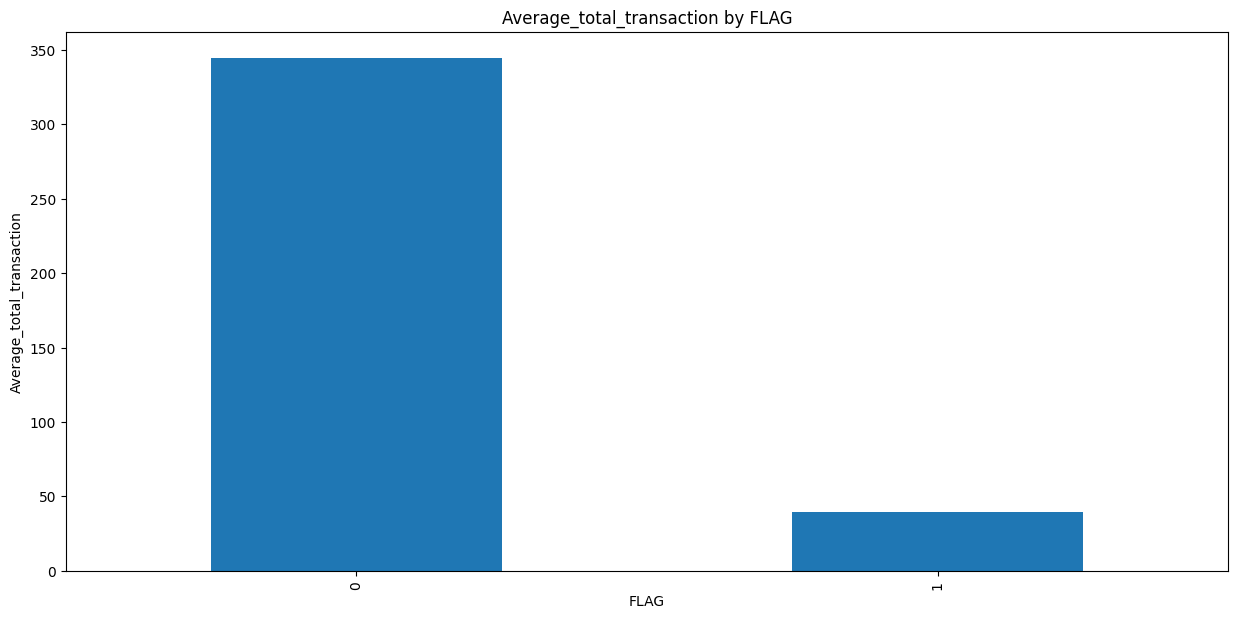

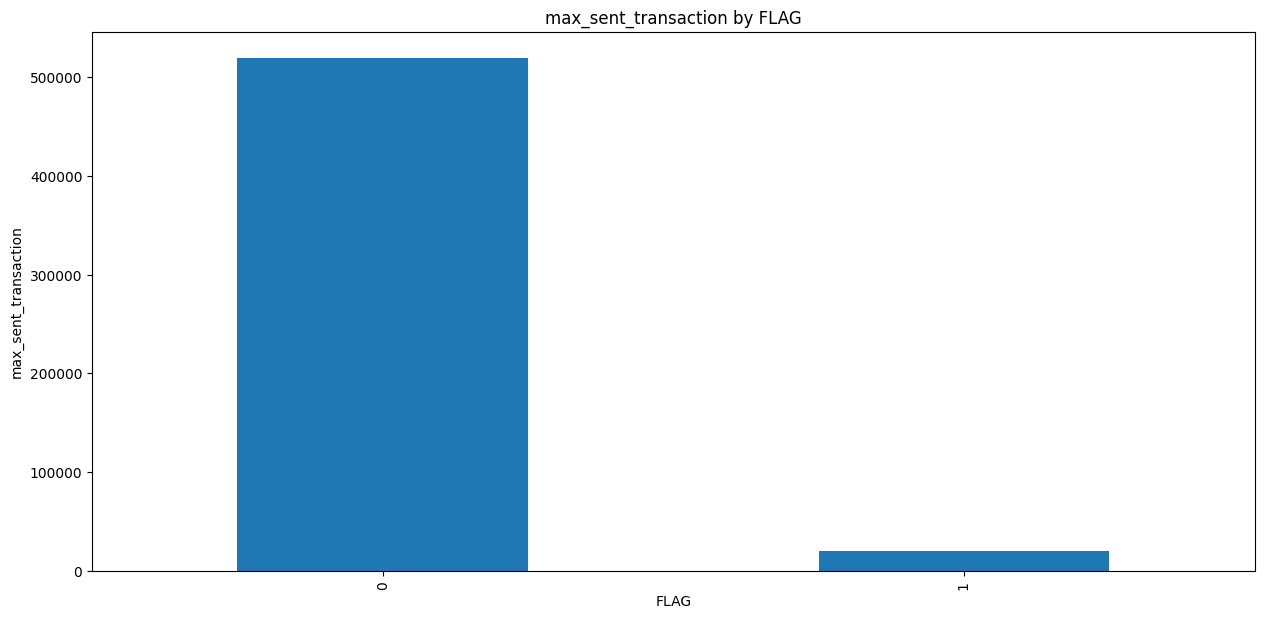

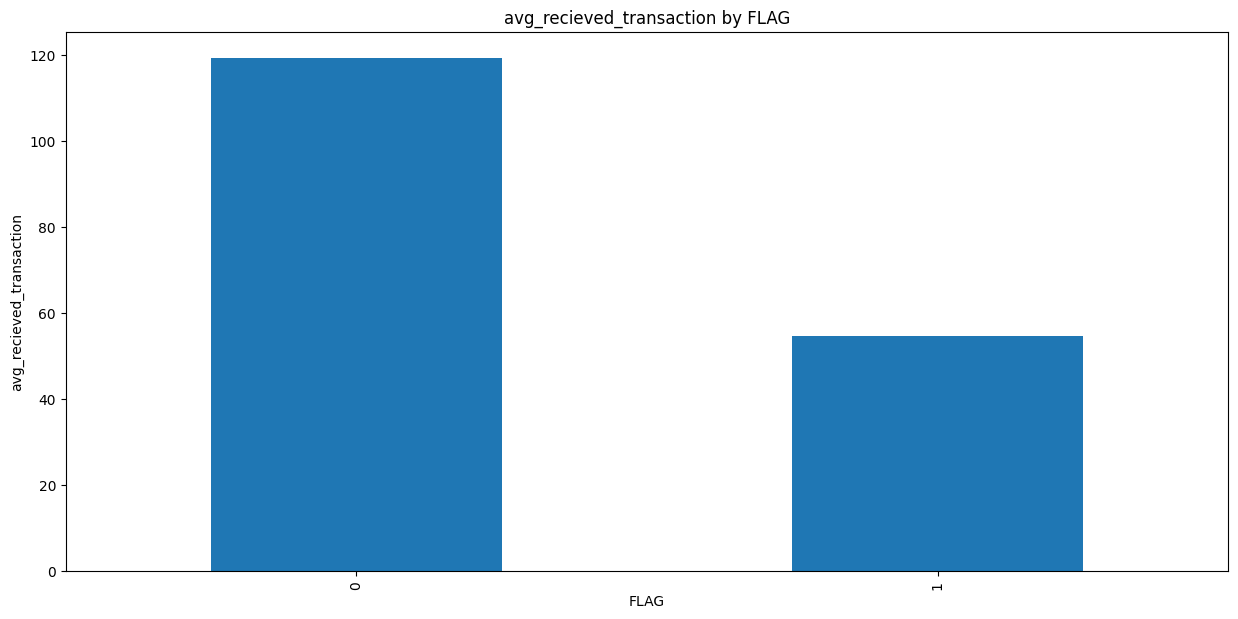

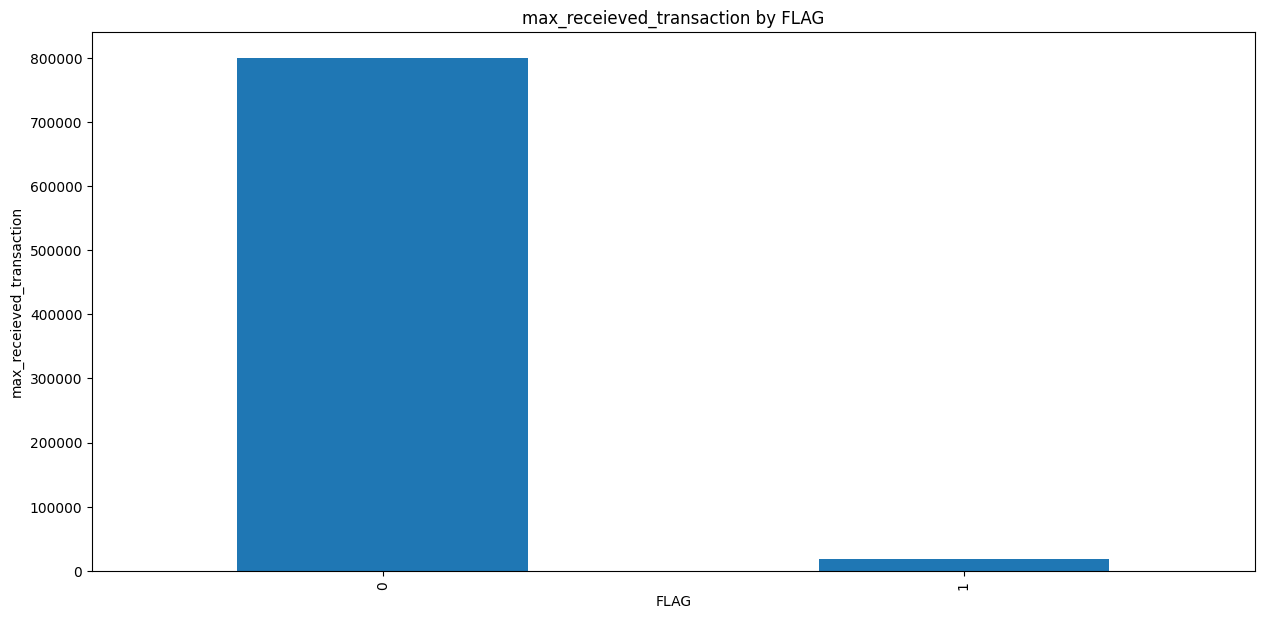

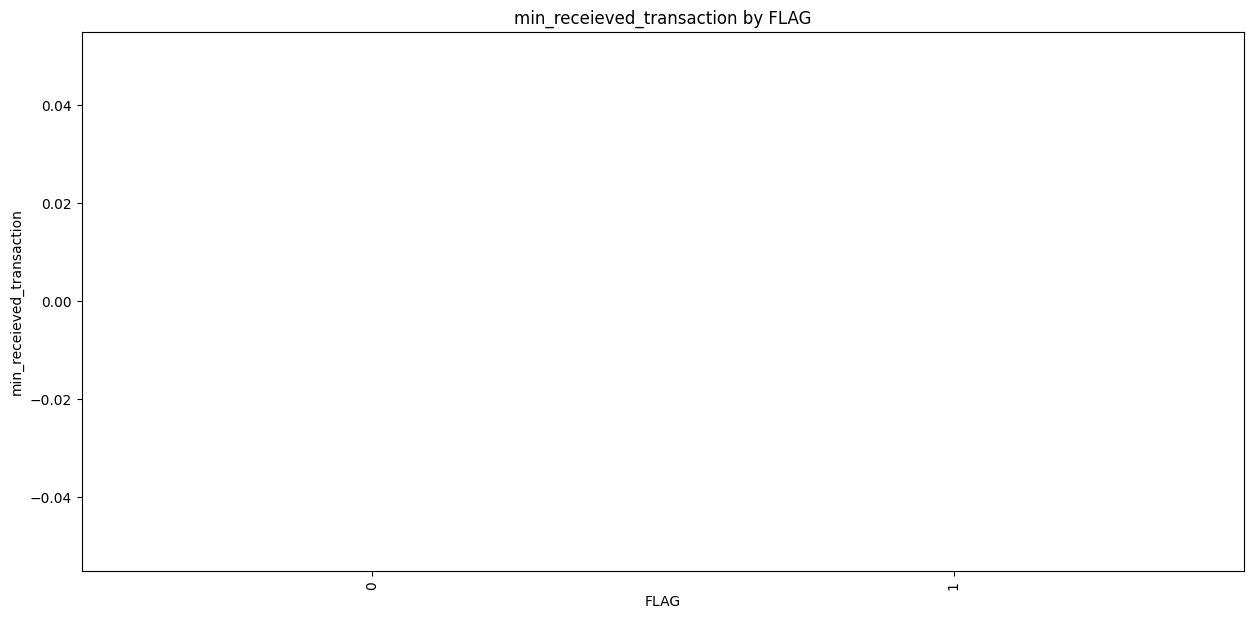

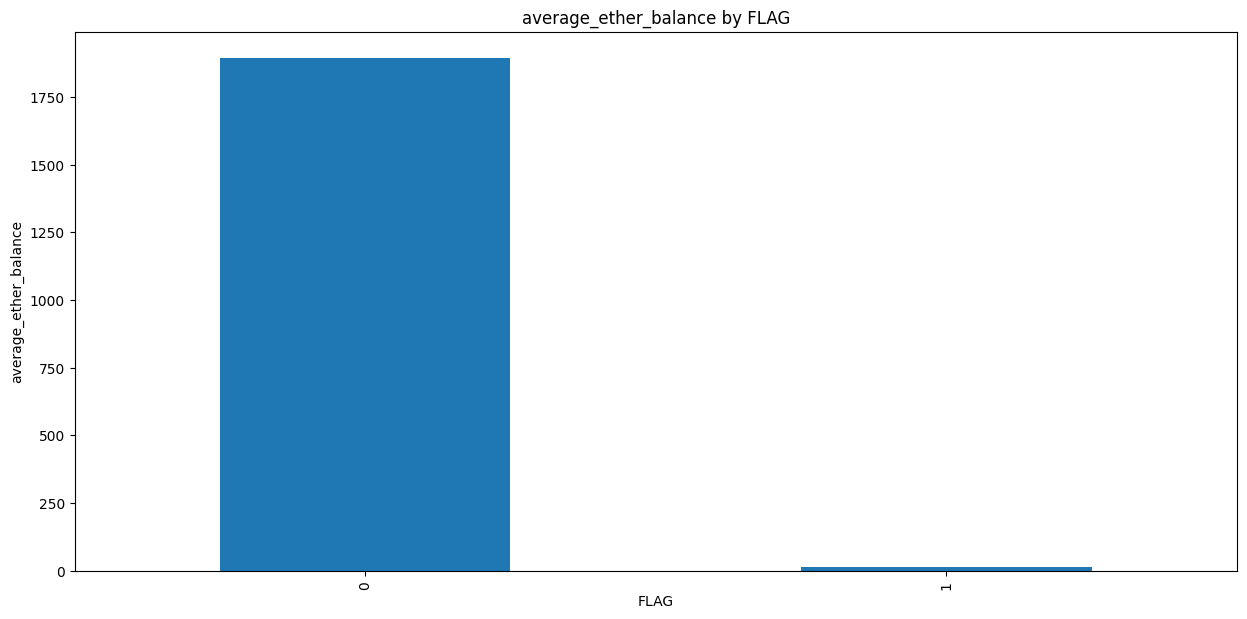

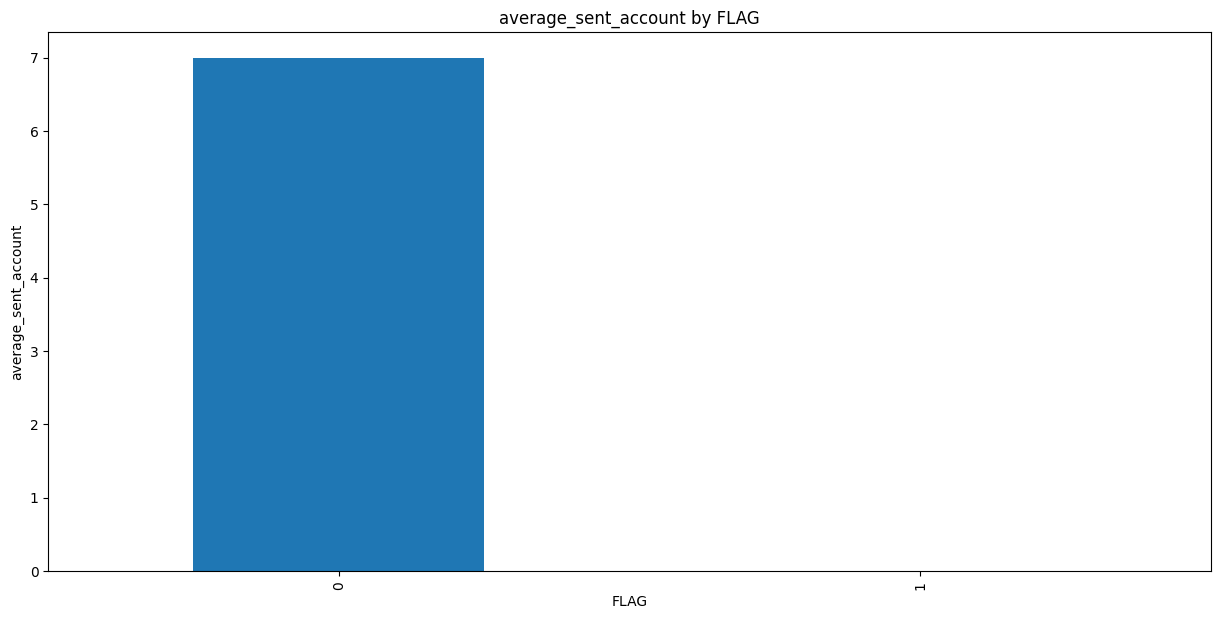

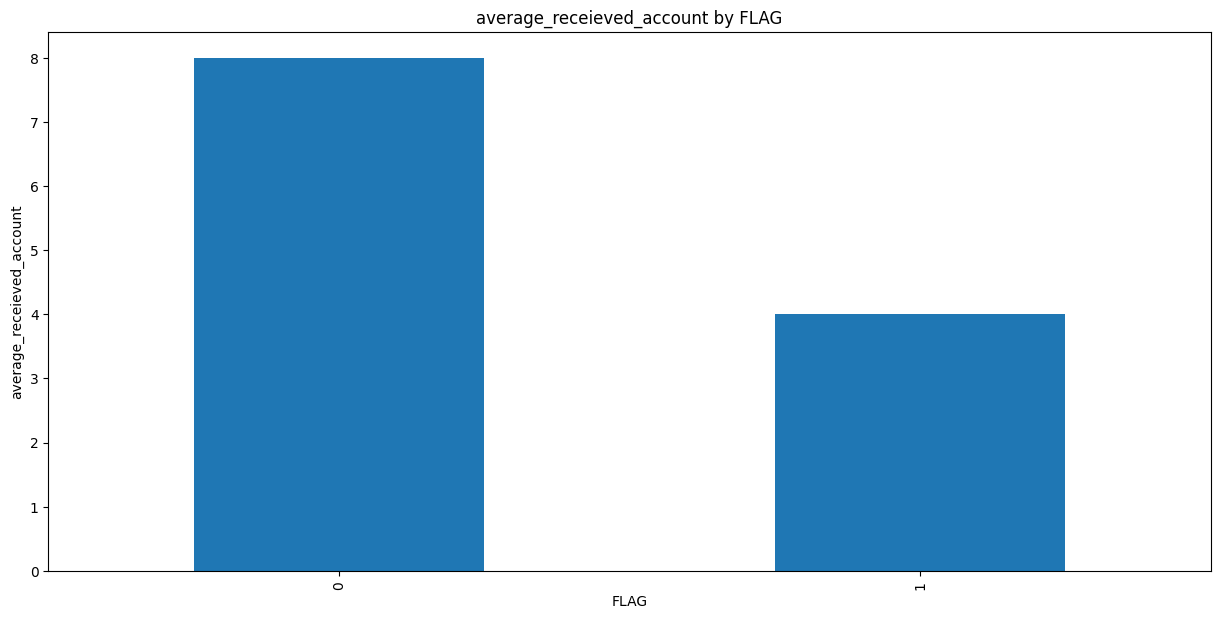

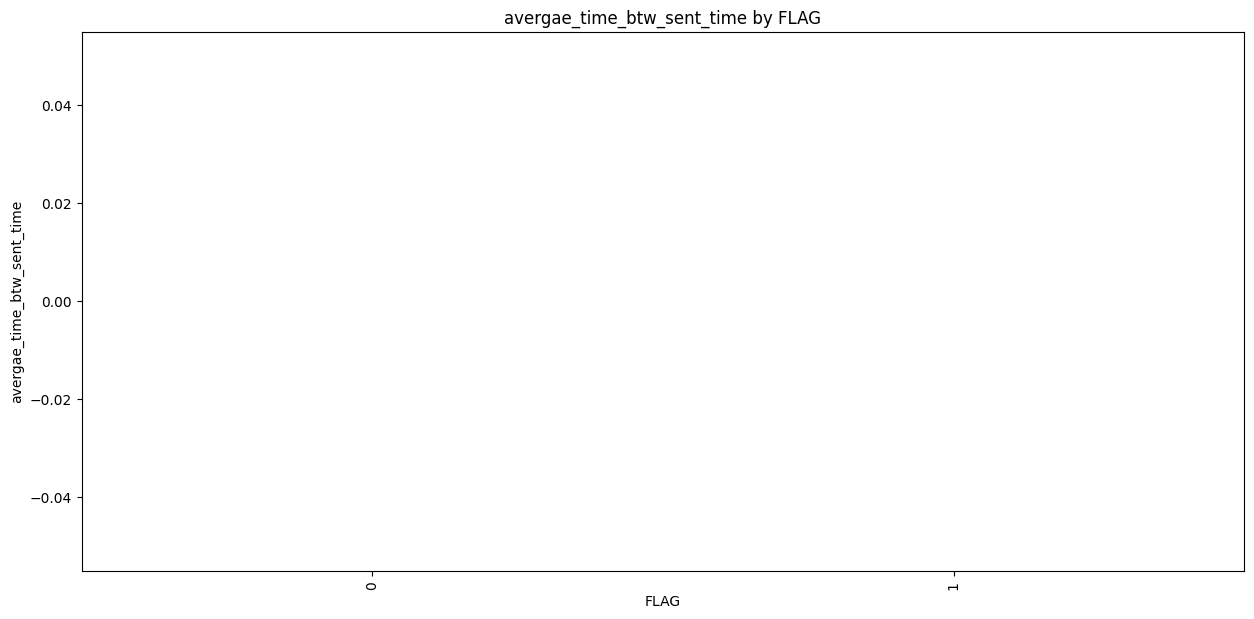

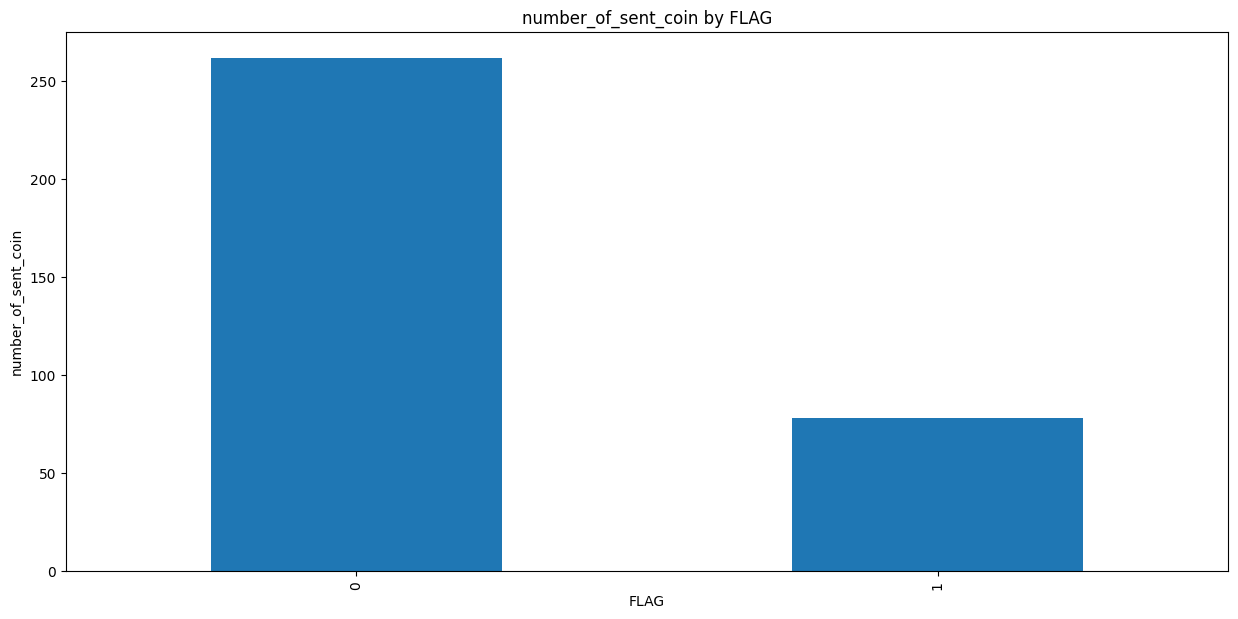

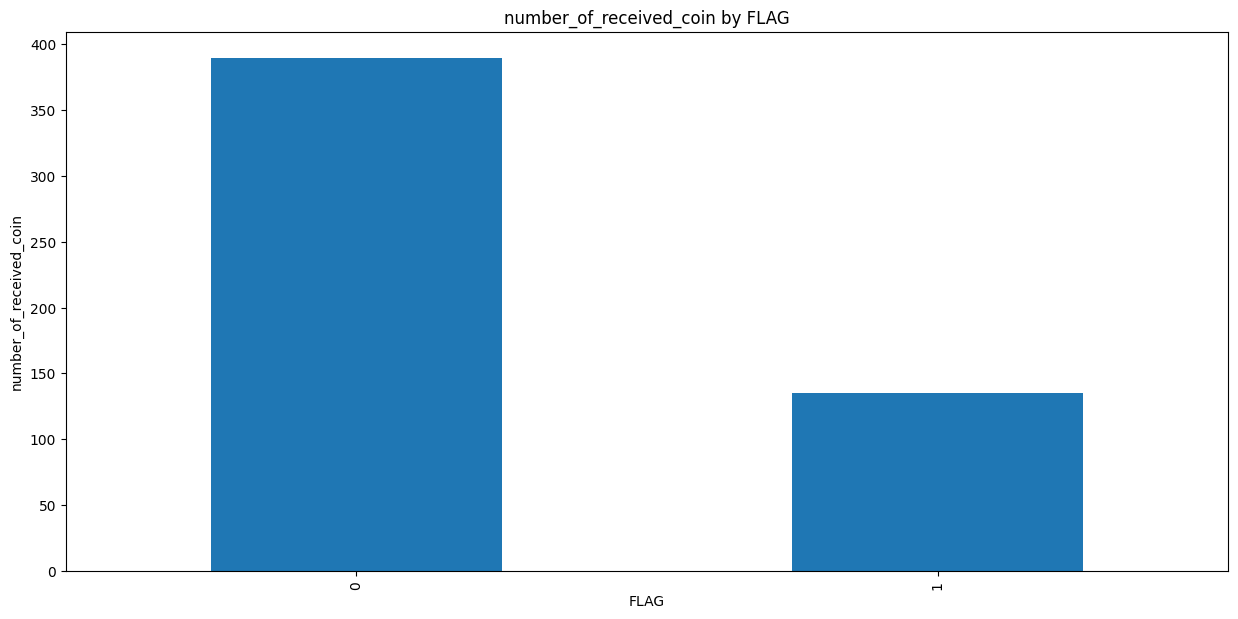

In [24]:
# Plot bar chart for the aggregated datA
for col in crypto_grouped:
    crypto_grouped[col].plot(kind='bar', figsize=(15, 7))
    # Adding plot title and labels
    plt.title(f'{col} by FLAG')
    plt.xlabel('FLAG')
    plt.ylabel(col)

    # Display the plot
    plt.show()

In [25]:
# check number of type of token transaction in the block i.e coin type
number_of_coin = crypto[' ERC20_most_rec_token_type'].nunique()
print(f'Number of received coins in dataset: {number_of_coin} coins \n')

# number of sent coin
number_of_coin = crypto[' ERC20 most sent token type'].nunique()
print(f'Number of sent coins in dataset: {number_of_coin} coins \n')

# Filter the DataFrame for rows where 'flag' is 0
fraudulent_transactions = crypto[crypto['FLAG'] == 0]

# Filter the DataFrame for rows where 'flag' is 1
non_fraudulent_transactions = crypto[crypto['FLAG'] == 1]

# Number of sent  coin flagged as fraudelent
number_of_coin = fraudulent_transactions[' ERC20 most sent token type'].nunique()
print(f'Number of sent coins flagged fraudulent in dataset: {number_of_coin} coins \n')

# Number of receieved coin flagged fraudulent
number_of_coin = fraudulent_transactions[' ERC20_most_rec_token_type'].nunique()
print(f'Number of received coins flagged fraudulent in dataset: {number_of_coin} coins \n')


# Number of sent  coin flagged as fraudelent
number_of_coin = non_fraudulent_transactions[' ERC20 most sent token type'].nunique()
print(f'Number of sent coins flagged non fraudulent in dataset: {number_of_coin} coins \n')

# Number of receieved coin flagged fraudulent
number_of_coin = non_fraudulent_transactions[' ERC20_most_rec_token_type'].nunique()
print(f'Number of received coins flagged non fraudulent in dataset: {number_of_coin} coins \n')


Number of received coins in dataset: 467 coins 

Number of sent coins in dataset: 305 coins 

Number of sent coins flagged fraudulent in dataset: 262 coins 

Number of received coins flagged fraudulent in dataset: 390 coins 

Number of sent coins flagged non fraudulent in dataset: 78 coins 

Number of received coins flagged non fraudulent in dataset: 135 coins 



## Preprocess Dataset

In [26]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8981 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            8981 non-null   int64  
 1   Index                                                 8981 non-null   int64  
 2   Address                                               8981 non-null   object 
 3   FLAG                                                  8981 non-null   int64  
 4   Avg min between sent tnx                              8981 non-null   float64
 5   Avg min between received tnx                          8981 non-null   float64
 6   Time Diff between first and last (Mins)               8981 non-null   float64
 7   Sent tnx                                              8981 non-null   int64  
 8   Received Tnx                                          8981

<ipython-input-27-8a92f2b32ec7>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



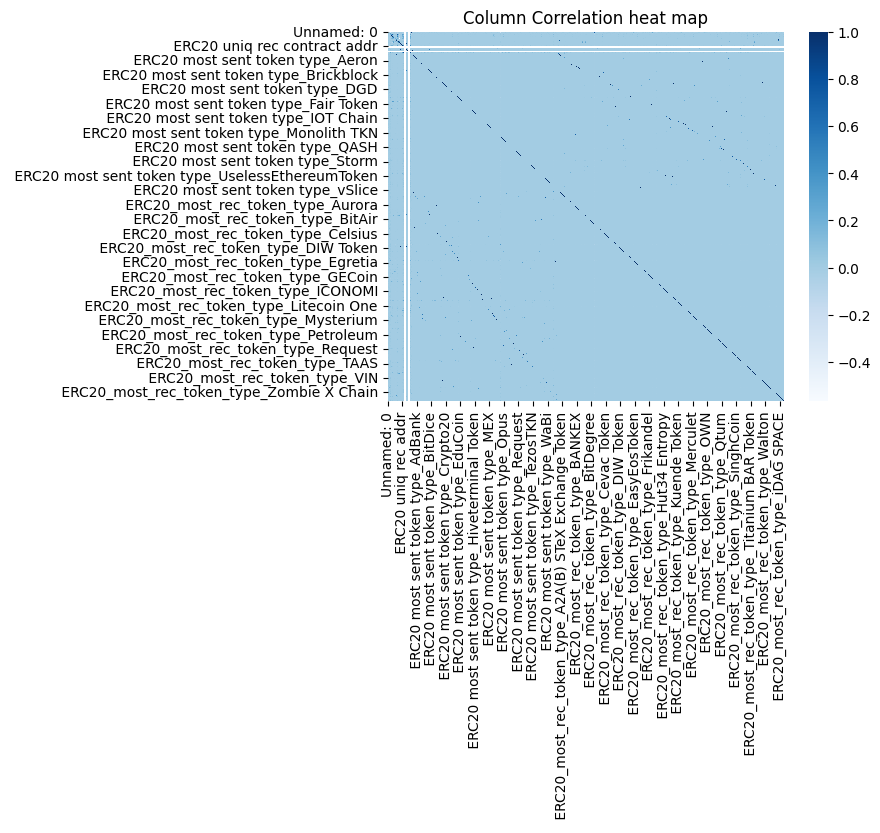

In [27]:
# Get dummie varibale for cstegorical column
crypto_prep = pd.get_dummies(crypto, columns=[' ERC20 most sent token type', ' ERC20_most_rec_token_type'])

# Correlation matrics
corr = crypto_prep.corr()

#plt heat map
# Plot the heatmap
heatmap = sns.heatmap(corr, cmap="Blues")

#add title
heatmap.set_title('Column Correlation heat map')

# Show the heatmap
plt.show()

# drop Columns 'Unnamed: 0', 'Adress' 'Index'
crypto_prep = crypto_prep.drop(columns=['Unnamed: 0', 'Index', 'Address'], axis=1)

In [28]:
crypto_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8981 entries, 0 to 9840
Columns: 818 entries, FLAG to  ERC20_most_rec_token_type_yocoinclassic
dtypes: float64(39), int64(7), uint8(772)
memory usage: 9.8 MB


In [29]:
# extract target variable from the dataset

x = crypto_prep.drop(columns=['FLAG'], axis=1)
y = crypto_prep['FLAG']

In [30]:
# calculate class weight
#compute class weight for training dataset
weight = compute_class_weight('balanced', classes = np.unique(y), y=y)
class_weight = {0: weight[0],
                1: weight[1]
                }
print(class_weight)

{0: 0.5884549862403354, 1: 3.326296296296296}


In [31]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# standardise train and test dataset
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Train models (Crypto Transaction)

In [32]:
# train base model for blockchain transaction
base_model(x_train_scaled, y_train, x_test_scaled, y_test, class_weight)

Training Logistic regression model
Epoch 1/10
180/180 [==============================] - 4s 6ms/step - loss: 0.6485 - accuracy: 0.8331 - precision: 0.4760 - recall: 0.8673 - f1_score: 0.6147 - val_loss: 0.7746 - val_accuracy: 0.9012 - val_precision: 0.6158 - val_recall: 0.9502 - val_f1_score: 0.7473
Epoch 2/10
180/180 [==============================] - 1s 4ms/step - loss: 0.4205 - accuracy: 0.9313 - precision: 0.7017 - recall: 0.9603 - f1_score: 0.8109 - val_loss: 1.0961 - val_accuracy: 0.9228 - val_precision: 0.6730 - val_recall: 0.9683 - val_f1_score: 0.7941
Epoch 3/10
180/180 [==============================] - 1s 4ms/step - loss: 0.2867 - accuracy: 0.9534 - precision: 0.7806 - recall: 0.9683 - f1_score: 0.8644 - val_loss: 1.4615 - val_accuracy: 0.9360 - val_precision: 0.7129 - val_recall: 0.9774 - val_f1_score: 0.8244
Epoch 4/10
180/180 [==============================] - 1s 4ms/step - loss: 0.2053 - accuracy: 0.9675 - precision: 0.8390 - recall: 0.9751 - f1_score: 0.9019 - val_loss:

### Insight
The deep learning and random forest model has the best accuracy during the base model training. The deep learning model will be choosen for further hyper parameter tuning and analysis on the test dataset.

## Hyper parameter funning

Learning rate per epoch:


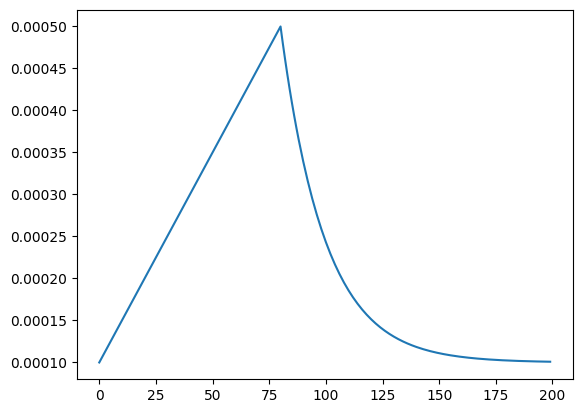

In [33]:
#setting up a learning rate scheduler for optimal training
EPOCHS = 200

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0005
rampup_epochs = 80
sustain_epochs = 0
exp_decay = 0.95

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [34]:
# Hyper parameter tunning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'
metrics = ['accuracy', 'Precision', 'Recall', tfa.metrics.F1Score(num_classes=1, threshold=0.5)]

def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ],
    name='deep_learning'
    )
    return model

model = model()
model.compile(
#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss= 'binary_crossentropy',
metrics=metrics
)
print('Training deep learning model')
history = model.fit(
    x_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[lr_callback]
    )

Training deep learning model

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/200
23/23 [==============================] - 2s 21ms/step - loss: 0.5969 - accuracy: 0.7982 - precision: 0.4278 - recall: 0.9331 - f1_score: 0.5866 - val_loss: 0.5762 - val_accuracy: 0.8942 - val_precision: 0.5977 - val_recall: 0.9548 - val_f1_score: 0.7352 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.000105.
Epoch 2/200
23/23 [==============================] - 0s 9ms/step - loss: 0.4251 - accuracy: 0.9165 - precision: 0.6561 - recall: 0.9580 - f1_score: 0.7788 - val_loss: 0.4296 - val_accuracy: 0.9325 - val_precision: 0.7183 - val_recall: 0.9231 - val_f1_score: 0.8079 - lr: 1.0500e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00011.
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2913 - accuracy: 0.9506 - precision: 0.7723 - recall: 0.9615 - f1_score: 0.8566 - val_loss: 0.3499 - val_accuracy: 0.9297 - val_preci

In [35]:
def train_result():

    training_result = {}

    training_metric = [
        'accuracy', 'precision',
        'recall', 'val_accuracy',
        'f1_score', 'val_f1_score',
        'val_precision', 'val_recall'
            ]

    training_loss = ['loss', 'val_loss']
    model_name = 'Deep learning'

    # convert f1_score from array to list
    f1_scores = [float(score) for score in history.history['f1_score']]
    history.history['f1_score'] = f1_scores

    val_f1_scores = [float(score) for score in history.history['val_f1_score']]
    history.history['val_f1_score'] = val_f1_scores

    #visualise training result

    #visualise training result
    result = pd.DataFrame(history.history)
    lineplot(result[training_metric], model_name)
    lineplot(result[training_loss], model_name)

train_result()

57/57 [==============================] - 0s 2ms/step
[[1514   36]
 [   6  241]]


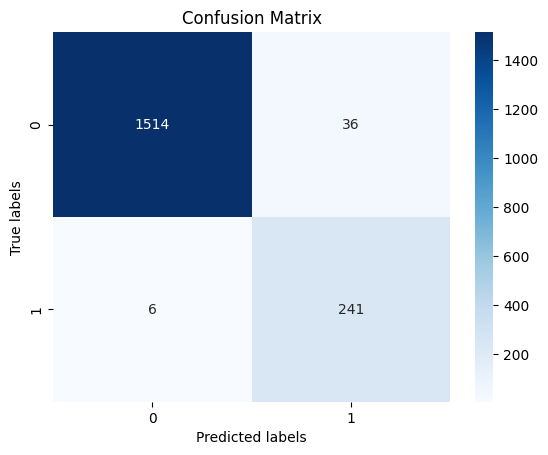

In [36]:
# Generate predictions
predictions = model.predict(x_test_scaled)

# Convert probabilities to class labels
# Assuming a binary classification (threshold 0.5)
predictions_labels = np.where(predictions > 0.5, 1, 0)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_labels)

# Print the confusion matrix
print(conf_matrix)

# Generate a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

# Add labels and title for clarity
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## insight

- **True Negatives (TN): 1539** - The number of non-fraudulent transactions (class 0) correctly identified as non-fraudulent.
- **False Positives (FP): 11** - The number of non-fraudulent transactions (class 0) incorrectly identified as fraudulent (class 1).
- **False Negatives (FN): 11** - The number of fraudulent transactions (class 1) incorrectly identified as non-fraudulent (class 0).
- **True Positives (TP): 236** - The number of fraudulent transactions (class 1) correctly identified as fraudulent.

In summary:
- The model correctly identified 1539 non-fraudulent and 236 fraudulent transactions.
- It incorrectly identified 11 non-fraudulent transactions as fraudulent and failed to identify 11 fraudulent transactions as such.

# Credit card Transaction


## Dataset Description
    Feature Explanation:
    
    distance_from_home - the distance from home where the transaction happened.

    distance_from_last_transaction - the distance from last transaction happened.

    ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.

    repeat_retailer - Is the transaction happened from same retailer.

    used_chip - Is the transaction through chip (credit card).

    used_pin_number - Is the transaction happened by using PIN number.

    online_order - Is the transaction an online order.

    fraud - Is the transaction fraudulent.

Reference `https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud`

## Data Cleaning

In [37]:
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  int64  
 4   used_chip                       1000000 non-null  int64  
 5   used_pin_number                 1000000 non-null  int64  
 6   online_order                    1000000 non-null  int64  
 7   fraud                           1000000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 61.0 MB


In [38]:
# check missing values
missing_credit_card = missing_value(df_credit_card)
missing_credit_card

,missing_values,% of total
distance_from_home,0,0.0
distance_from_last_transaction,0,0.0
ratio_to_median_purchase_price,0,0.0
repeat_retailer,0,0.0
used_chip,0,0.0
used_pin_number,0,0.0
online_order,0,0.0
fraud,0,0.0


### insight
There are no missing values in thr credit_card dataset

## Exploratory Data Analysis

In [39]:
# class distribution
# create class flag dictionary from the flag column
class_fraud = df_credit_card['fraud'].value_counts().to_dict()

palette = px.colors.sequential.Cividis

# Extract keys and values
labels = list(class_fraud.keys())
values = list(class_fraud.values())

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,
                             hole=0.4,
                             marker=dict(colors=palette)
                             )]
)

# Adjust font and text properties
fig.update_traces(textposition='outside', textinfo='percent+label',
                  marker=dict(line=dict(color='#000000', width=1)))

# Adjust layout
fig.update_layout(
    title='Pie Chart of Flag credit card transactions class',
    title_font=dict(size=24, family='Arial'),
    legend=dict(
        title='Flaged',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5
    )
)

fig.show()



### Insight
The class distribution of fraudulent and non fraudulent transactions are highly unbalance just like what was implemnted in the blockchain eda. The same class weight solution will be implemented for the credit card dataset.

In [40]:
grouped_credit_card_df = df_credit_card.groupby(['fraud', 'online_order', 'used_pin_number']).agg(
    no_of_transaction=('used_chip', 'count'),
    average_distance_from_home=('distance_from_home', 'mean'),
    average_disance_from_last_transaction=('distance_from_last_transaction', 'mean')
)

# Resetting index to make 'fraud', 'online_order', and 'used_pin_number' columns instead of multi-index
grouped_credit_card_df = grouped_credit_card_df.reset_index()

# Plotting
grouped_credit_card_df

,fraud,online_order,used_pin_number,no_of_transaction,average_distance_from_home,average_disance_from_last_transaction
0,0,0,0,309558,25.891891,4.786127
1,0,0,1,35198,26.474897,4.942106
2,0,1,0,502704,20.325167,3.886288
3,0,1,1,65137,25.682133,4.855113
4,1,0,0,4691,85.041036,21.885610
5,1,0,1,1,111.807949,64.035949
6,1,1,0,82439,64.897911,12.116707
7,1,1,1,272,155.619886,34.795969


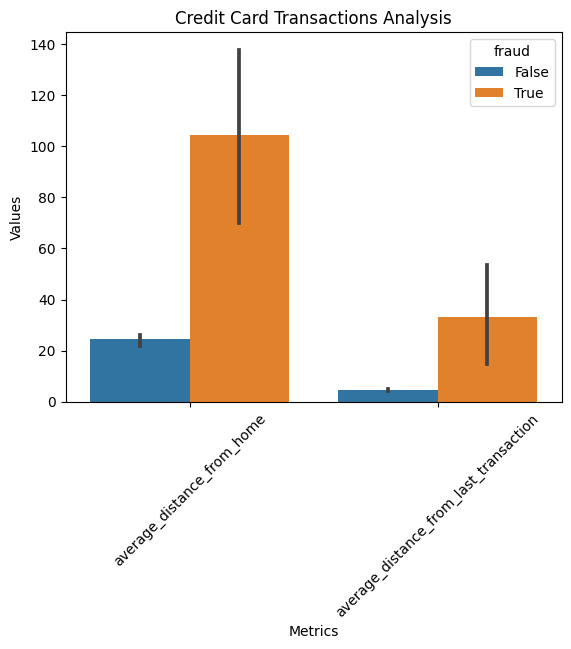

In [41]:
# Assuming df_credit_card is your initial DataFrame
grouped_df = df_credit_card.groupby(['fraud', 'online_order', 'used_pin_number']).agg(
    no_of_fraudulent_transaction=('used_chip', 'count'),
    average_distance_from_home=('distance_from_home', 'mean'),
    average_distance_from_last_transaction=('distance_from_last_transaction', 'mean')
)

# Resetting index to make 'fraud', 'online_order', and 'used_pin_number' columns instead of multi-index
grouped_df = grouped_df.reset_index()
grouped_df['fraud'].replace({1:True, 0:False}, inplace=True)
# Melting the DataFrame to have a better format for plotting
melted_df = grouped_df.melt(id_vars=['fraud', 'online_order', 'used_pin_number'],
                            value_vars=['average_distance_from_home', 'average_distance_from_last_transaction'])


sns.barplot(x='variable', y='value', hue='fraud', data=melted_df)

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Credit Card Transactions Analysis')
plt.xticks(rotation=45)  # Rotating x-axis labels for better visibility

# Display the plot
plt.show()


In [42]:
grouped_df

,fraud,online_order,used_pin_number,no_of_fraudulent_transaction,average_distance_from_home,average_distance_from_last_transaction
0,False,0,0,309558,25.891891,4.786127
1,False,0,1,35198,26.474897,4.942106
2,False,1,0,502704,20.325167,3.886288
3,False,1,1,65137,25.682133,4.855113
4,True,0,0,4691,85.041036,21.885610
5,True,0,1,1,111.807949,64.035949
6,True,1,0,82439,64.897911,12.116707
7,True,1,1,272,155.619886,34.795969


### Insight
From the plot above it can be observe that fradulent credit card transactions occurs farther away from home compared to non-fraudulent transactions. The average distance between a fraudlent transaction and the last transaction is also greater for a fraudulent case. Which means fraudulent transactions are mostly initiated far from the last legal transaction intiated.

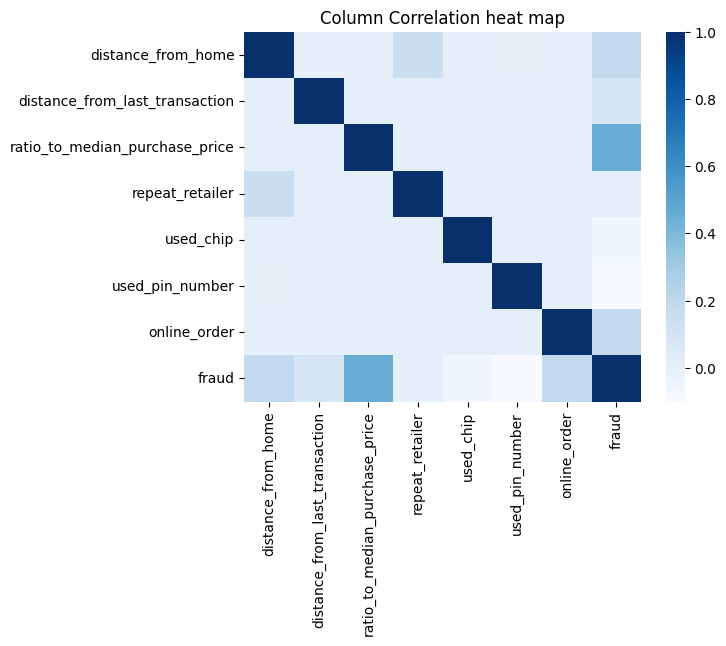

In [43]:
# Correlation matrix
corr = df_credit_card.corr()

#plt heat map
# Plot the heatmap
heatmap = sns.heatmap(corr, cmap="Blues")

#add title
heatmap.set_title('Column Correlation heat map')

# Show the heatmap
plt.show()


### Insight
The ratio to median purchase price feature is more correlated to the target variable fraud.

# Preprocessing

In [44]:
x = df_credit_card.drop(columns=['fraud'], axis=1)
y = df_credit_card['fraud']

In [45]:
# calculate class weight
#compute class weight for training dataset
weight = compute_class_weight('balanced', classes = np.unique(y), y=y)
class_weight = {0: weight[0],
                1: weight[1]
                }
print(class_weight)

{0: 0.5478869643446121, 1: 5.720627438417446}


In [46]:
# train test split
x_train, x_test, y_train_cred, y_test_cred = train_test_split(x, y, test_size=0.2, random_state=123)

# standardise train and test dataset
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled_cred = scaler.transform(x_train)
x_test_scaled_cred = scaler.transform(x_test)

In [47]:
# train base model for blockchain transaction
base_model(x_train_scaled_cred, y_train_cred, x_test_scaled_cred, y_test_cred, class_weight, batch_size=4096)

Training Logistic regression model
Epoch 1/10
157/157 [==============================] - 4s 17ms/step - loss: 0.5833 - accuracy: 0.6385 - precision: 0.1652 - recall: 0.7727 - f1_score: 0.2723 - val_loss: 0.6132 - val_accuracy: 0.6808 - val_precision: 0.1889 - val_recall: 0.8037 - val_f1_score: 0.3059
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.4920 - accuracy: 0.7155 - precision: 0.2126 - recall: 0.8326 - f1_score: 0.3387 - val_loss: 0.5417 - val_accuracy: 0.7643 - val_precision: 0.2508 - val_recall: 0.8521 - val_f1_score: 0.3876
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.4274 - accuracy: 0.7987 - precision: 0.2863 - recall: 0.8711 - f1_score: 0.4310 - val_loss: 0.4870 - val_accuracy: 0.8273 - val_precision: 0.3225 - val_recall: 0.8838 - val_f1_score: 0.4725
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 0.3810 - accuracy: 0.8425 - precision: 0.3459 - recall: 0.8971 - f1_score: 0.4993 - val_loss

### Insight
The deep learning model performance was the best of the 3 based model with exceptional accuracy precision recall. The deep learning model will be choose for further hyper parameter tuning and analysis on the test dataset.

## Hyper paRAMETER TUNNING

Learning rate per epoch:


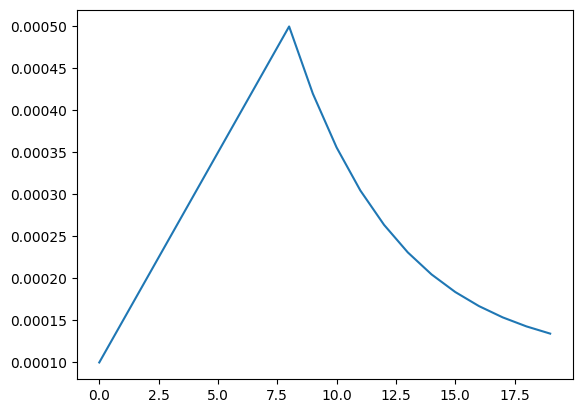

In [48]:
#setting up a learning rate scheduler for optimal training
EPOCHS = 20

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0005
rampup_epochs = 8
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [49]:
# Hyper parameter tunning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'
metrics = ['accuracy', 'Precision', 'Recall', tfa.metrics.F1Score(num_classes=1, threshold=0.5)]

def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled_cred.shape[1]), dtype='float32'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ],
    name='deep_learning'
    )
    return model

model = model()
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss= 'binary_crossentropy',
metrics=metrics
)
print('Training deep learning model')
history = model.fit(
    x_train_scaled_cred,
    y_train_cred,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[lr_callback]
    )

Training deep learning model

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/20
2500/2500 [==============================] - 14s 5ms/step - loss: 0.0421 - accuracy: 0.9817 - precision: 0.8298 - recall: 0.9952 - f1_score: 0.9050 - val_loss: 0.0338 - val_accuracy: 0.9929 - val_precision: 0.9329 - val_recall: 0.9901 - val_f1_score: 0.9607 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00015000000000000001.
Epoch 2/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0146 - accuracy: 0.9936 - precision: 0.9334 - recall: 0.9980 - f1_score: 0.9646 - val_loss: 0.0667 - val_accuracy: 0.9915 - val_precision: 0.9218 - val_recall: 0.9864 - val_f1_score: 0.9530 - lr: 1.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0002.
Epoch 3/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0139 - accuracy: 0.9945 - precision: 0.9427 - recall: 0.9980 - f1_score: 0.9696 - val_loss: 0.0166 - val_accu

In [50]:
def train_result():

    training_result = {}

    training_metric = [
        'accuracy', 'precision',
        'recall', 'val_accuracy',
        'val_precision', 'val_recall',
        'f1_score', 'val_f1_score'
            ]

    training_loss = ['loss', 'val_loss']
    model_name = 'Deep learning'
    #visualise training result

    # convert f1_score from array to list
    f1_scores = [float(score) for score in history.history['f1_score']]
    history.history['f1_score'] = f1_scores

    val_f1_scores = [float(score) for score in history.history['val_f1_score']]
    history.history['val_f1_score'] = val_f1_scores

    result = pd.DataFrame(history.history)
    fig1 = lineplot(result[training_metric], model_name)
    fig2 = lineplot(result[training_loss], model_name)

train_result()

6250/6250 [==============================] - 11s 2ms/step
[[182370    242]
 [    15  17373]]


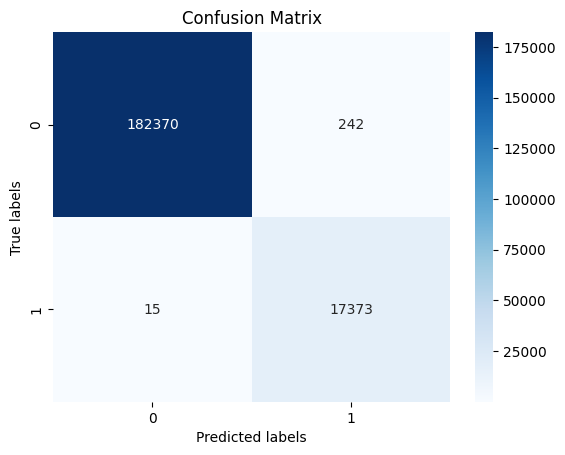

In [51]:
# Generate predictions
predictions = model.predict(x_test_scaled_cred)

# Convert probabilities to class labels
# Assuming a binary classification (threshold 0.5)
predictions_labels = np.where(predictions > 0.5, 1, 0)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_cred, predictions_labels)

# Print the confusion matrix
print(conf_matrix)

# Generate a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

# Add labels and title for clarity
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Insight

- **True Negatives (TN): 182,310** - The number of negative (non-fraudulent) cases correctly identified as negative. This means that 182,310 non-fraudulent transactions were accurately recognized by the model.
- **False Positives (FP): 302** - The number of negative cases incorrectly classified as positive (fraudulent). In your case, 302 non-fraudulent transactions were wrongly labeled as fraudulent.
- **False Negatives (FN): 9** - The number of positive (fraudulent) cases incorrectly classified as negative (non-fraudulent). This indicates that 9 fraudulent transactions were missed by the model and classified as non-fraudulent.
- **True Positives (TP): 17,379** - The number of positive cases correctly identified as positive. Here, 17,379 fraudulent transactions were correctly detected.

This confusion matrix suggests that the model is quite effective at detecting both fraudulent and non-fraudulent transactions, with a high number of true positives and true negatives and relatively low numbers of false positives and false negatives. However, even a small number of false negatives can be critical in contexts like fraud detection, as each missed fraudulent transaction can have significant consequences.

# Reference
- https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset/
- Credit Card Fraud https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud